In [ ]:
!conda install -c conda-forge missingno -y


   id   Age  Gender  Stage  GeneticRisk  TreatmentType  ComorbidityIndex  \
0   0  65.0       0      2          1.0              0               0.0   
1   1  68.0       1      2          0.0              1               1.0   
2   2  68.0       1      3          1.0              1               0.0   
3   3  81.0       1      4          1.0              1               3.0   
4   4  59.0       1      2          1.0              0               NaN   

   TreatmentResponse  SurvivalTime  Censored  
0                0.0           4.2         0  
1                1.0           4.7         1  
2                1.0           3.5         1  
3                0.0           2.3         0  
4                0.0           NaN         0  


<Axes: >

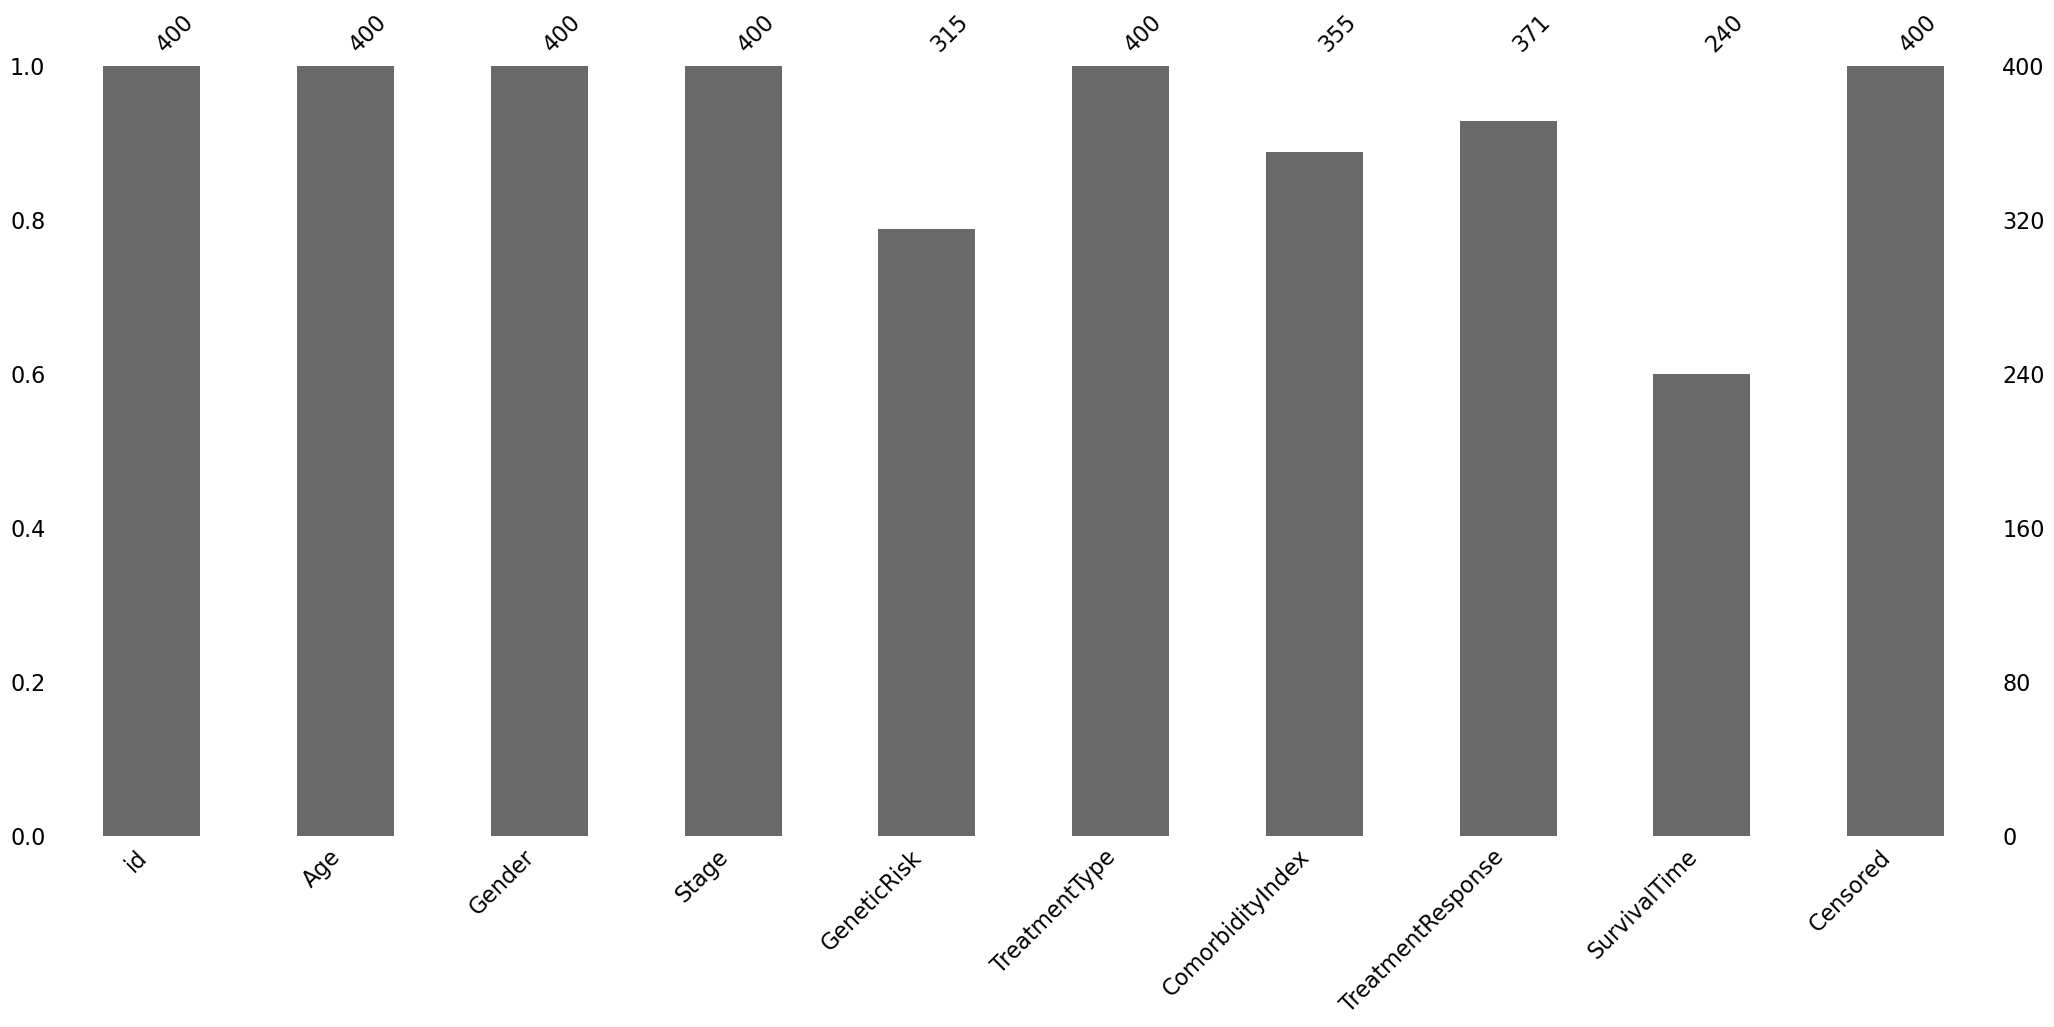

In [1]:
import pandas as pd
import missingno as msno

# Charger le dataset
df = pd.read_csv('data/train_data.csv')
test=pd.read_csv('data/test_data.csv')

# Afficher un aperçu des premières lignes
print(df.head())

# Visualiser les valeurs manquantes sous forme de bar plot
msno.bar(df)


<Axes: >

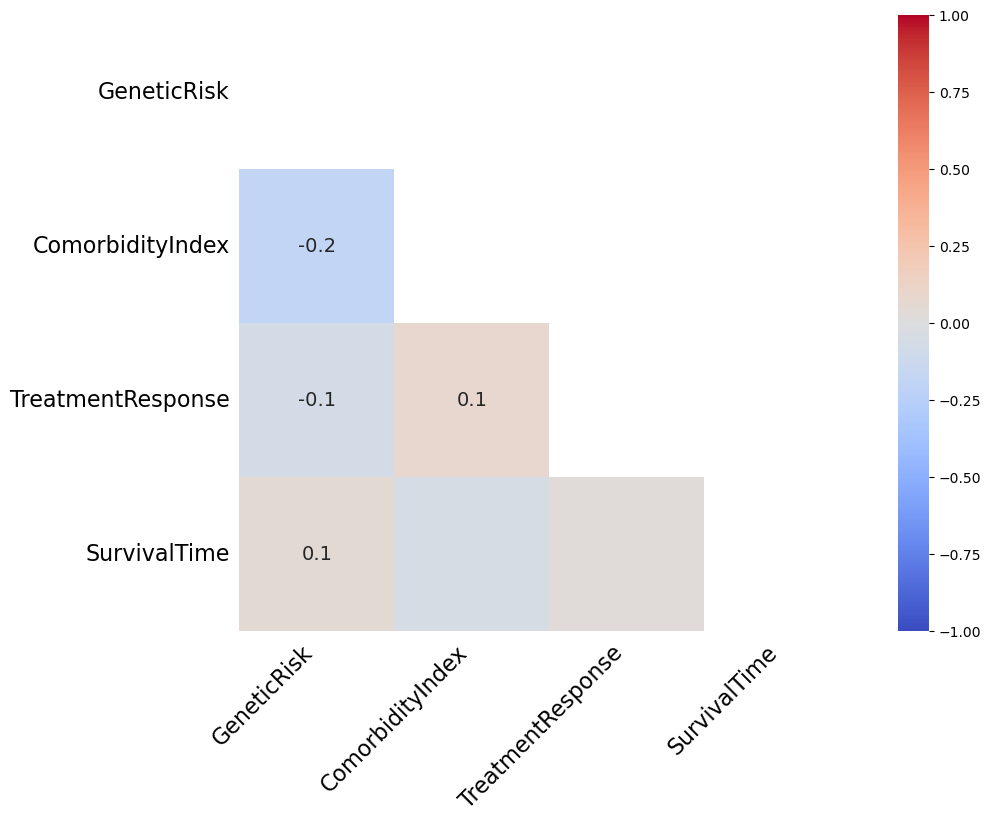

In [2]:
msno.heatmap(df, figsize=(10, 8), cmap="coolwarm")


<Axes: >

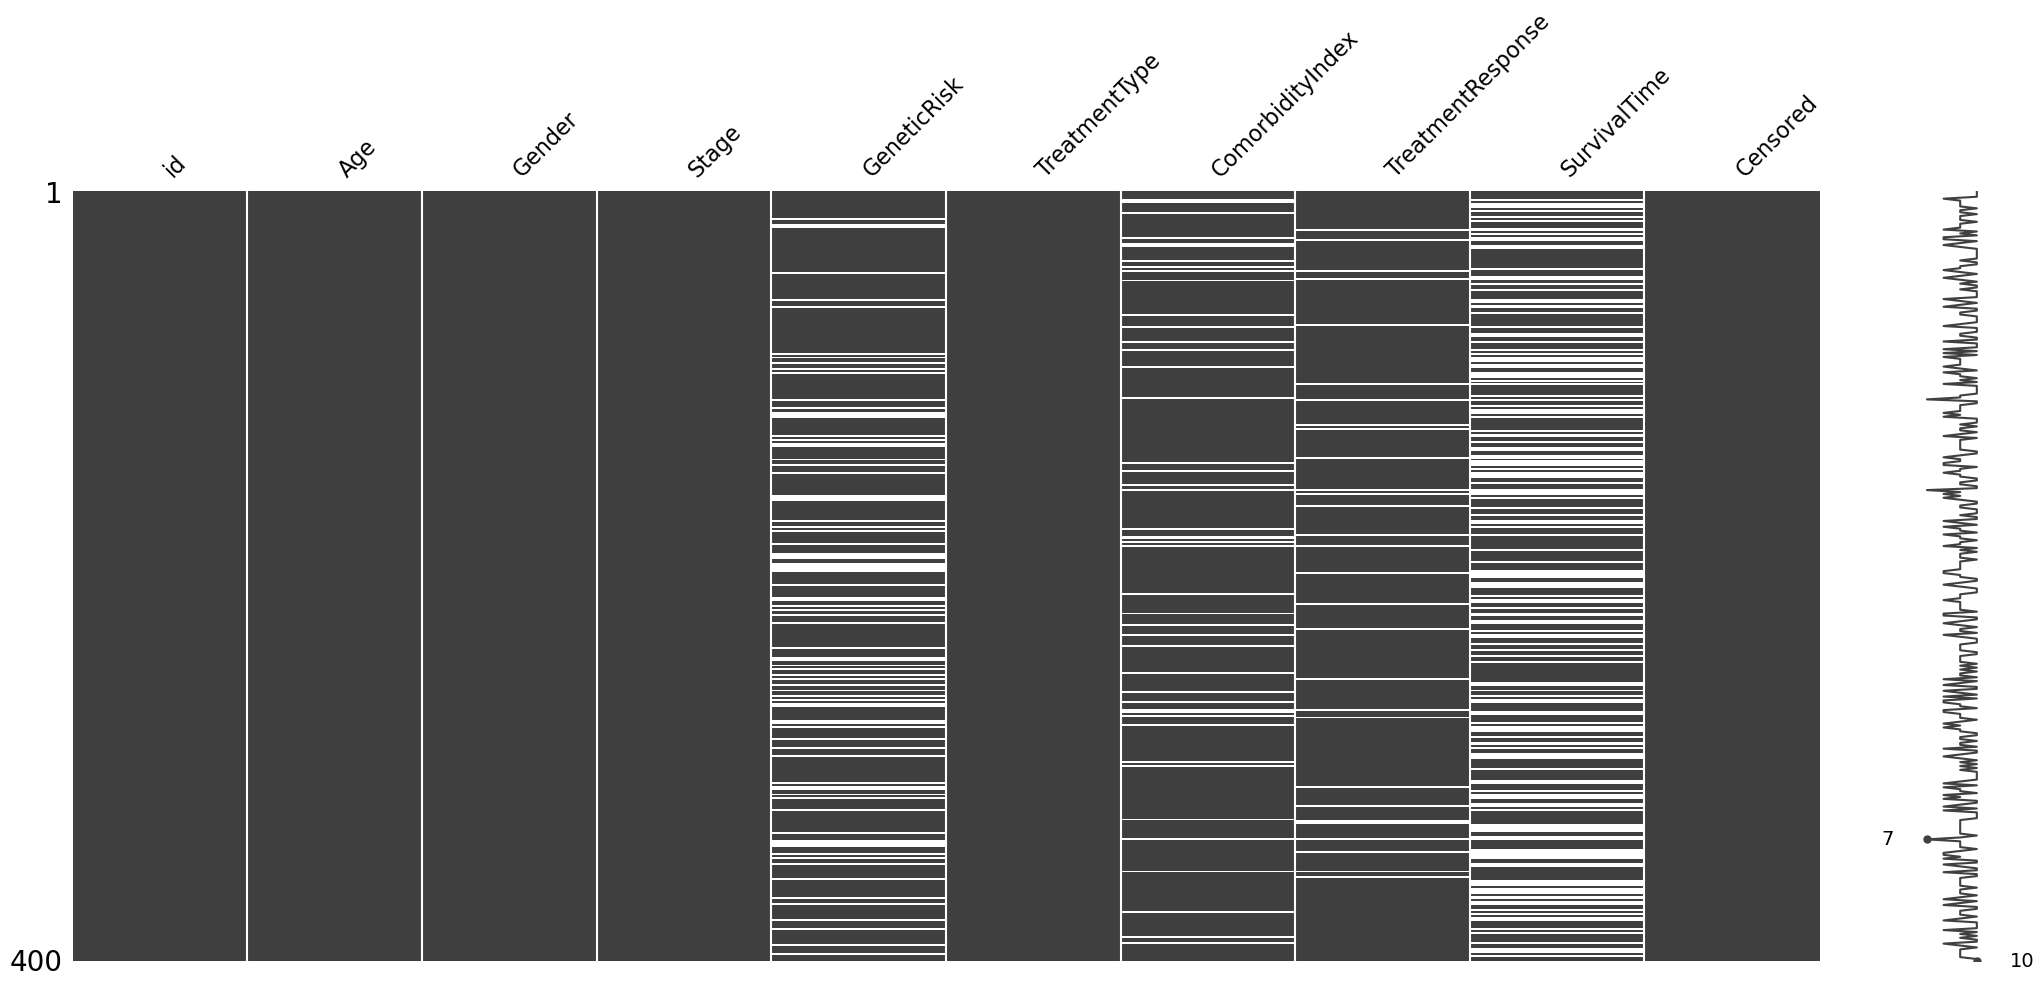

In [3]:
msno.matrix(df)

<Axes: >

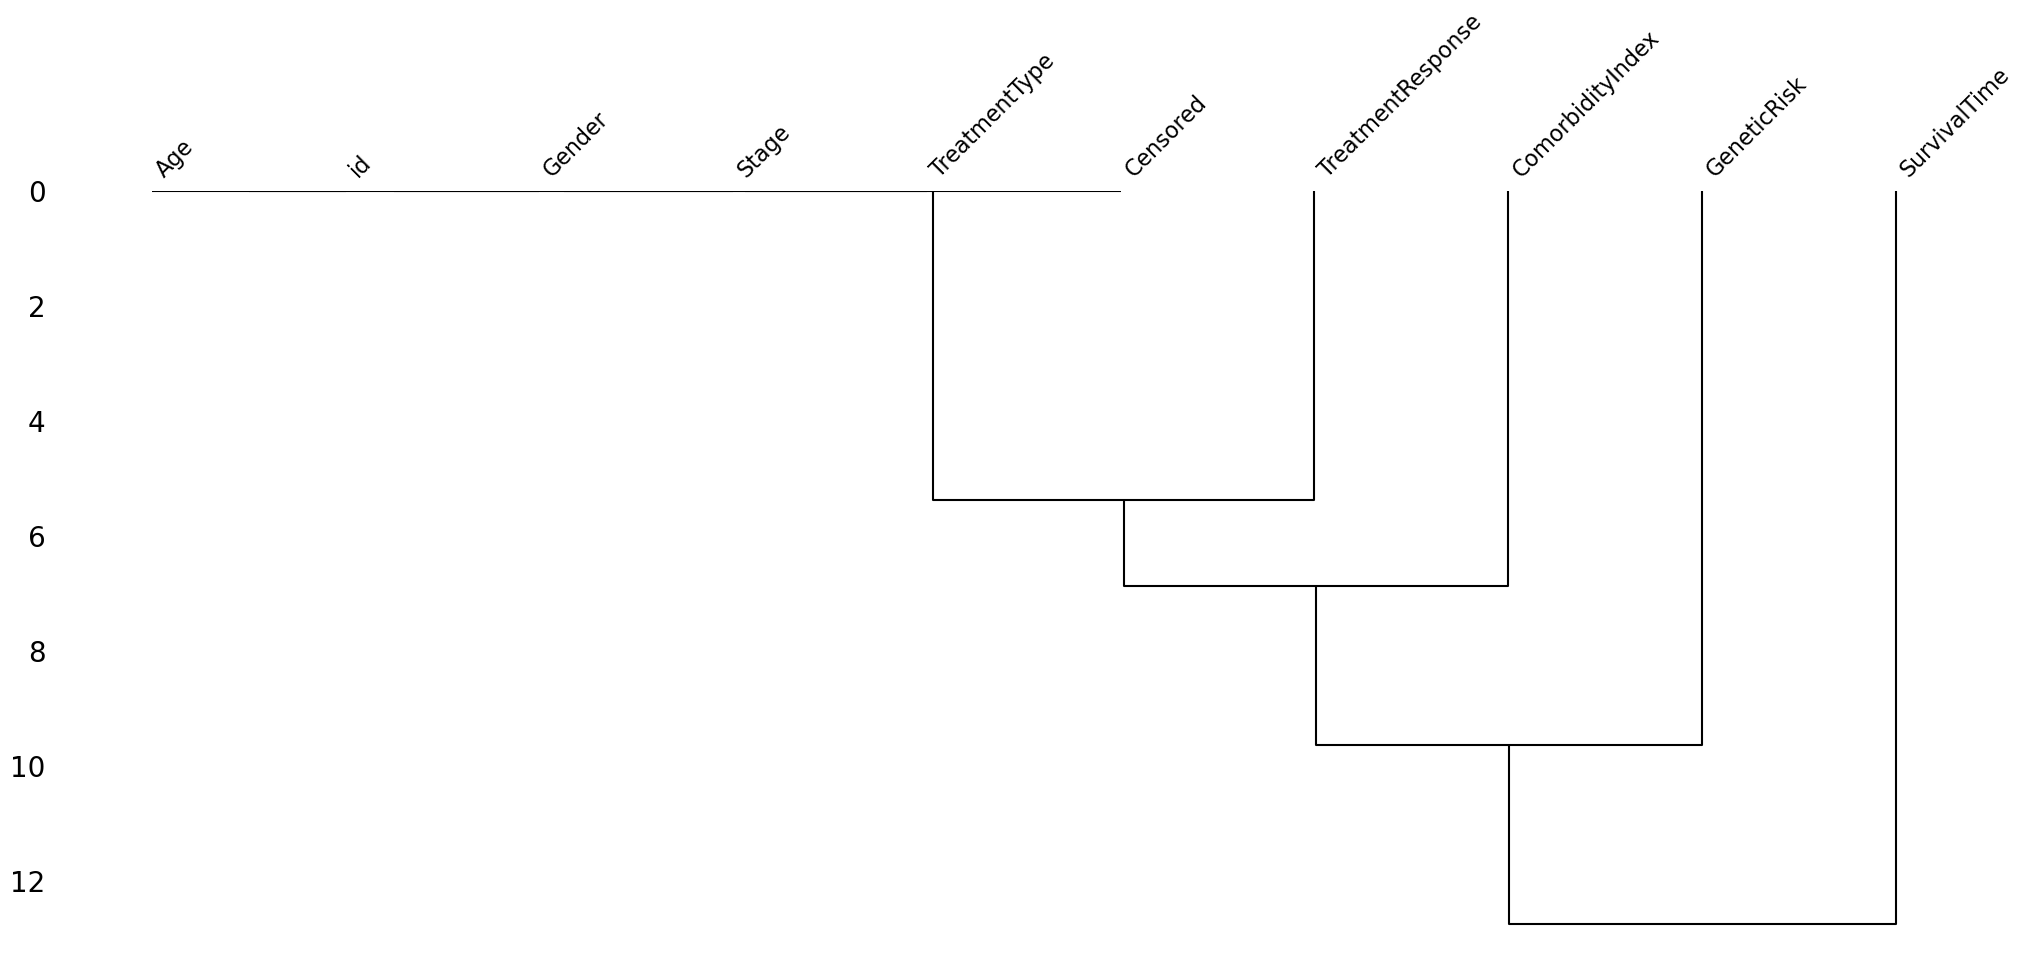

In [4]:
msno.dendrogram(df)

In [5]:
print(f"Censored Patients: {(df['Censored'] == 1).sum()}")

Censored Patients: 79


In [6]:
# Columns with missing values
cols_with_missing = df.columns[df.isnull().any()].tolist()
print(f"Columns with missing values: {cols_with_missing}")

# drop them
df_reduced = df.drop(columns=cols_with_missing)

Columns with missing values: ['GeneticRisk', 'ComorbidityIndex', 'TreatmentResponse', 'SurvivalTime']


In [7]:
df_reduced = df_reduced[df_reduced['Censored'] == 0]
print(f"Final Dataset: {df_reduced.shape[0]} patients, {df_reduced.shape[1]} features")


Final Dataset: 321 patients, 6 features


['id', 'Age', 'Gender', 'Stage', 'TreatmentType', 'Censored']


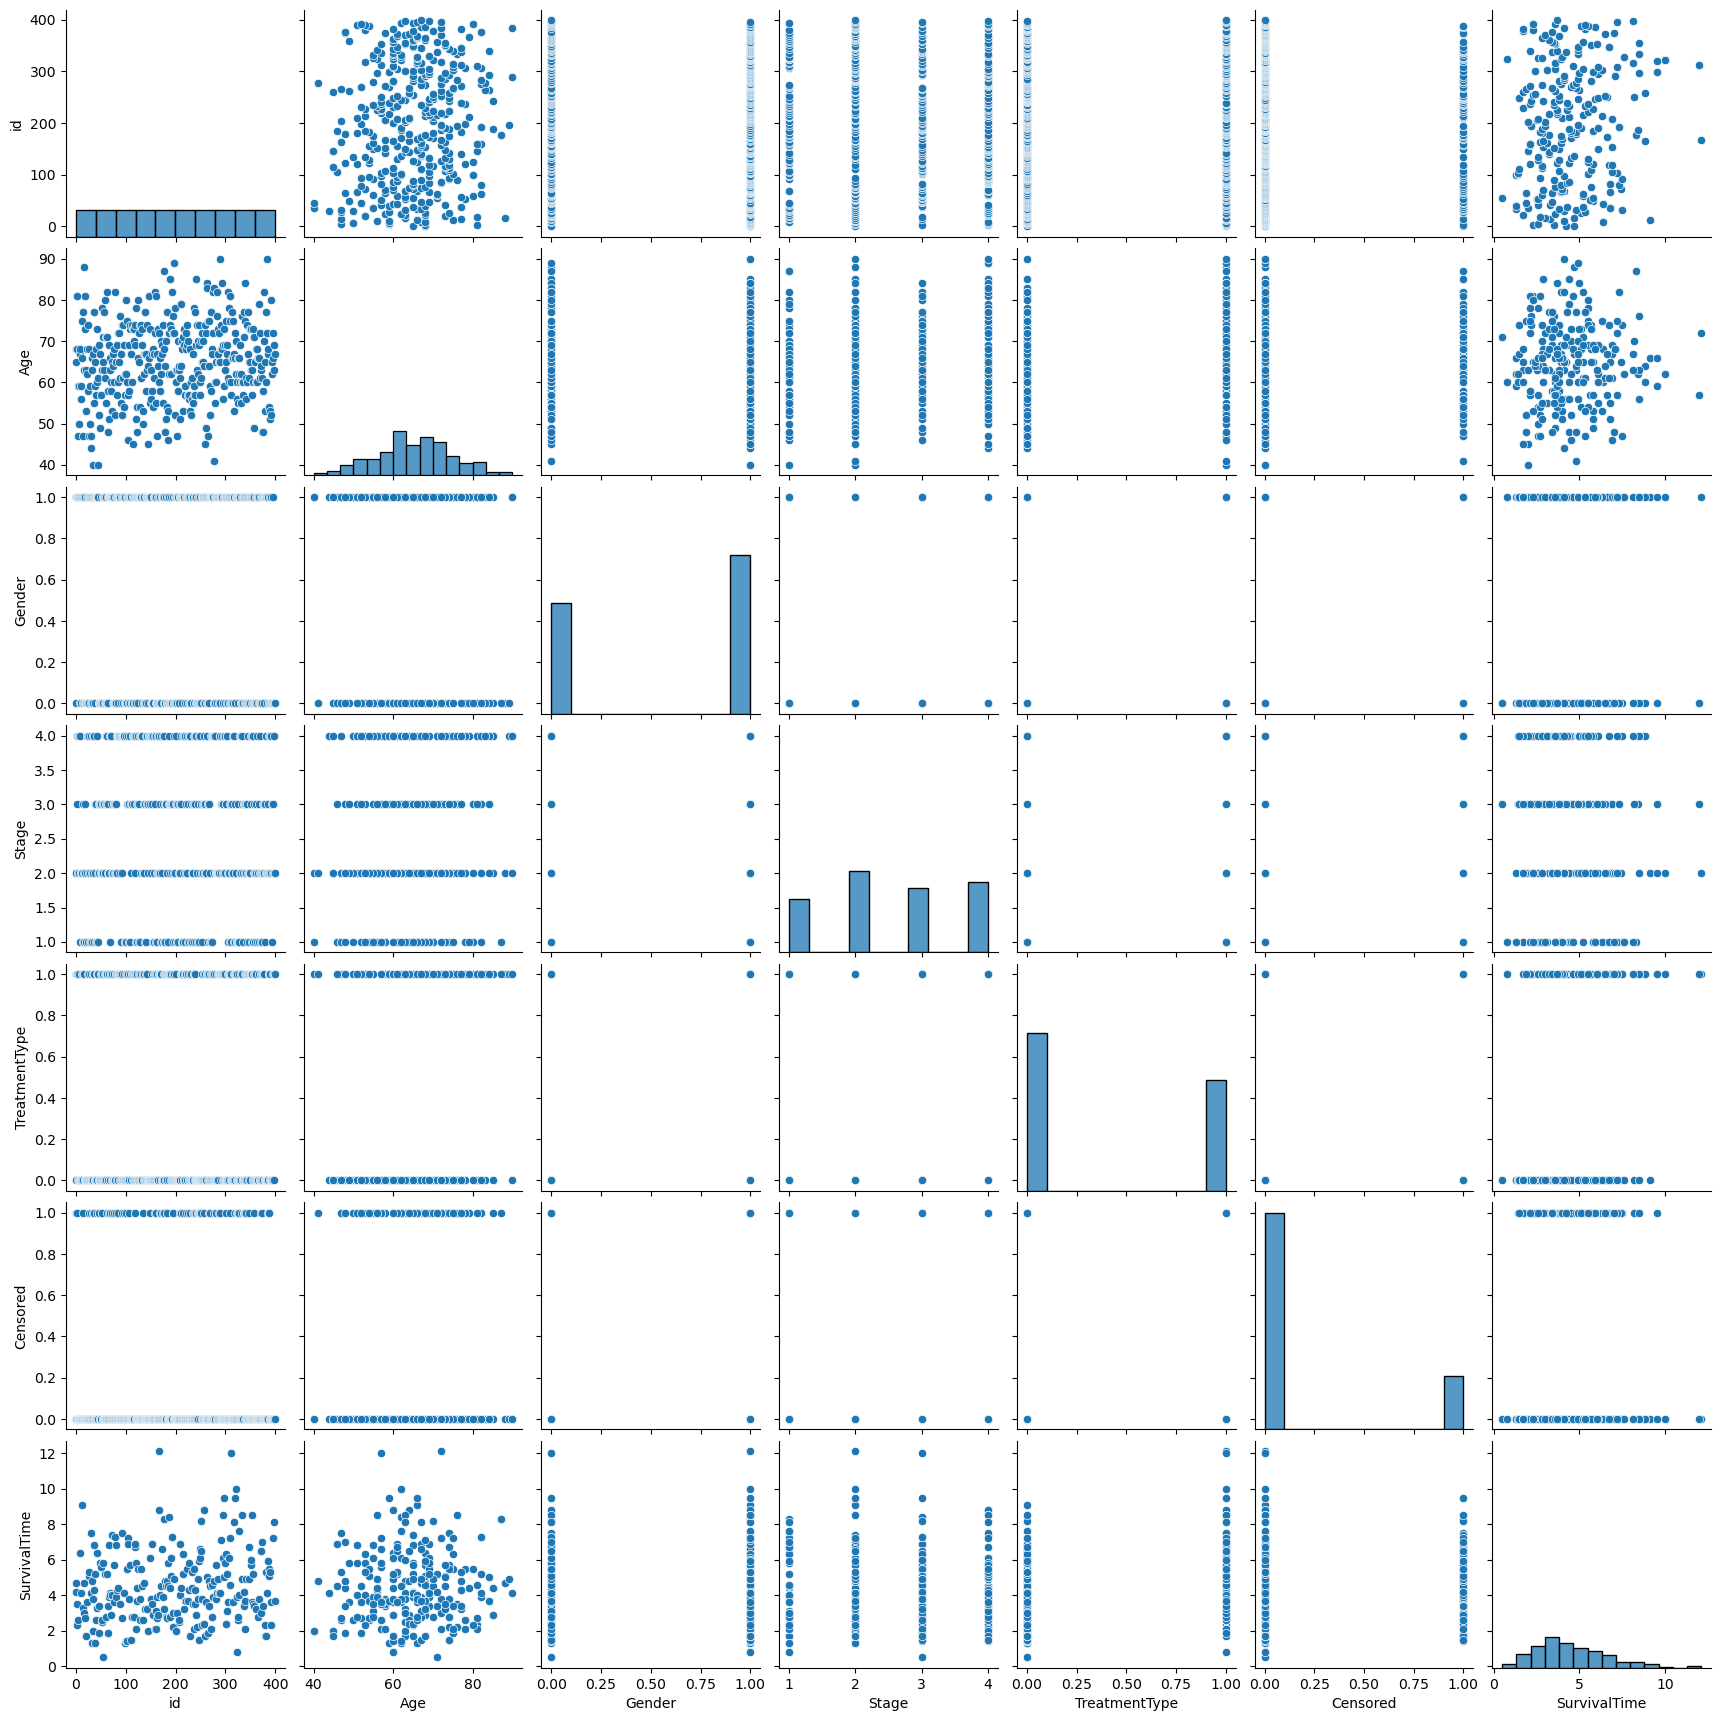

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
columns_without_missing=df.columns[df.notnull().all()].tolist()
print(columns_without_missing)
plot_columns=  df.columns[df.notnull().all()].tolist() + ['SurvivalTime']
sns.pairplot(df[plot_columns])
plt.show()


In [9]:
# Trouver l'intersection des indices entre df_reduced et les SurvivalTime non manquants
valid_indices = df.dropna(subset=['SurvivalTime']).index
common_indices = df_reduced.index.intersection(valid_indices)

X = df_reduced.loc[common_indices].drop(columns=['Censored'])
y = df.loc[common_indices, 'SurvivalTime']

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")


X shape: (161, 5)
y shape: (161,)


In [10]:

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Split 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train: {len(X_train)} patients ({len(X_train)/len(X)*100:.1f}%)")
print(f"Test:  {len(X_test)} patients ({len(X_test)/len(X)*100:.1f}%)")
baseline_model = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

# Cross-validation on train set
cv_scores = cross_val_score(baseline_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(X_train.columns.tolist())
baseline_model.fit(X_train, y_train)

# 5. PRÉDICTIONS SUR TEST SET
y_pred = baseline_model.predict(X_test)




Train: 128 patients (79.5%)
Test:  33 patients (20.5%)
['id', 'Age', 'Gender', 'Stage', 'TreatmentType']


In [11]:
def error_metric(y, y_hat, c):
    import numpy as np
    err = y-y_hat
    err = (1-c)*err**2 + c*np.maximum(0,err)**2
    return np.sum(err)/err.shape[0]

In [12]:
c_test = np.zeros_like(y_test)
cMSE_baseline = error_metric(y_test, y_pred, c_test)

print(f"cMSE Baseline: {cMSE_baseline:.2f}")
print(f"RMSE Baseline: {np.sqrt(cMSE_baseline):.2f} ")

cMSE Baseline: 4.31
RMSE Baseline: 2.08 


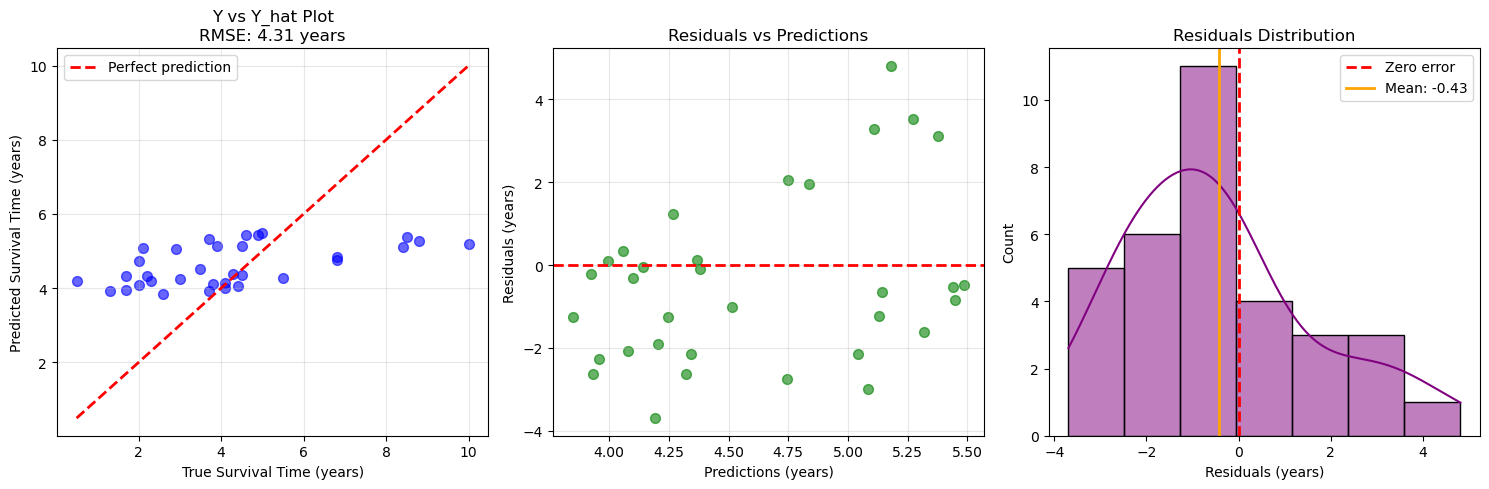

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 3. Y-Y HAT PLOT
plt.figure(figsize=(15, 5))

# Subplot 1: Y vs Y_hat
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred, alpha=0.6, s=50, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect prediction')
plt.xlabel('True Survival Time (years)')
plt.ylabel('Predicted Survival Time (years)')
plt.title(f'Y vs Y_hat Plot\nRMSE: {cMSE_baseline:.2f} years')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Residuals vs Predictions
plt.subplot(1, 3, 2)
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.6, s=50, color='green')
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predictions (years)')
plt.ylabel('Residuals (years)')
plt.title('Residuals vs Predictions')
plt.grid(True, alpha=0.3)

# Subplot 3: Residuals distribution
plt.subplot(1, 3, 3)
sns.histplot(residuals, kde=True, color='purple')
plt.axvline(x=0, color='r', linestyle='--', lw=2, label='Zero error')
plt.axvline(x=residuals.mean(), color='orange', linestyle='-', lw=2, label=f'Mean: {residuals.mean():.2f}')
plt.xlabel('Residuals (years)')
plt.title('Residuals Distribution')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
X_kaggle = test[['id', 'Age', 'Gender', 'Stage', 'TreatmentType']].copy()
target_columns=['id', 'Age', 'Gender', 'Stage', 'TreatmentType','SurvivalTime']
predictions = baseline_model.predict(X_kaggle)
output=pd.DataFrame({
    'PatientID': test['id'],      # Les IDs du test set
    'SurvivalTime': predictions   # Les prédictions du modèle
})
output.to_csv('baseline-submission-01.csv', index=False)